# Dependencies

In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 26kB/s 
     |████████████████████████████████| 512kB 31.0MB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=01e8d2fcf87e53aba94ece65697778a9a0f19d31e6b9d4347b1821e55864200c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras import regularizers, constraints
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# GAN

In [3]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 128
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    def norm_loss(y_real, y_pred):
      squared_distance = tf.square(y_real - y_pred)
      # we want to maximize this distance,
      # However, if the labels that we are using, are the inverse of the norm, we do not need to reverse the result of our mean squard error
      # but, if the labels are not the inverse of the norm, we should inverse the result of the loss function
      squared_distance_reverse = tf.math.sqrt (tf.reduce_mean(squared_distance, axis=-1))
      return 1/squared_distance_reverse

    z = Input(shape=(self.latent_dim,))
        
    img , distance = self.generator(z)

    self.discriminator.trainable = False

    validity = self.discriminator(img)

    self.combined = Model(z, [validity, distance])
    self.combined.compile(loss=['binary_crossentropy' , norm_loss], optimizer=optimizer)
    
  def build_generator(self):
    #My functional code
    input_layer = Input(shape=(self.latent_dim,))
    layer = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(512, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(1024, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)

    out1 = Dense(np.prod(self.img_shape), activation='tanh' )(layer)
    out1 = Reshape(self.img_shape)(out1)

    # output 2 is dependent to the output 1
    out2 = GlobalAveragePooling2D()(out1)
    out2 =  Dense(1, activation='relu')(out2)

    # output 2 is independent to the output 1
    #out2 =  Dense(1, activation='relu')(layer)

    noise = input_layer
    img = out1
    distance = out2

    model = Model(noise, [img,distance])
    model.summary()
    return model

    #Baseline Sequential code
    #model = Sequential()
    #model.add(Dense(256, input_dim=self.latent_dim))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(1024))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    #model.add(Reshape(self.img_shape))
    #model.summary()
    #noise = Input(shape=(self.latent_dim,))
    #img = model(noise)
    #return Model(noise, img)
        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)


  #def train(self, epochs, batch_size=128, sample_interval=60):
  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
      
      
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
  

      imgs = X_train[idx]
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs, distances = self.generator.predict(noise)

      d_loss_real = self.discriminator.train_on_batch(imgs, valid)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))


      # calculte the labels for second output which is the distance between generated images (all fake images without the current image feeding to the network)
      fake_data_discrimination = []

      for i in range(0,len(gen_imgs)):
        other_generated_images = []
        for j in range(0,len(gen_imgs)):
          #for each generated data, we should consider the distance beween this sample with others (not itself)
          if j!=i:
            other_generated_images.append(gen_imgs[j])

        #fake_data_discrimination.append(1/(np.linalg.norm(other_generated_images))) 
        fake_data_discrimination.append(np.linalg.norm(other_generated_images))
      fake_data_discrimination = np.array(fake_data_discrimination)

          
      g_loss = self.combined.train_on_batch(noise, [valid,fake_data_discrimination])
      
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G loss: %f loss]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs, distances = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()

In [4]:
if __name__ == '__main__':
    gan = GAN()
    #gan.train(epochs=20000, batch_size=64, sample_interval=1000)
    gan.train(epochs=26000, batch_size=64, sample_interval=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params:

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.701639, acc.: 61.72%] [G loss: 0.821748, G loss: 0.799710 loss]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
21001 [D loss: 0.680625, acc.: 58.59%] [G loss: 0.862288, G loss: 0.857577 loss]
21002 [D loss: 0.634153, acc.: 61.72%] [G loss: 0.927335, G loss: 0.922583 loss]
21003 [D loss: 0.629344, acc.: 64.06%] [G loss: 0.900657, G loss: 0.895939 loss]
21004 [D loss: 0.668937, acc.: 60.16%] [G loss: 0.938431, G loss: 0.933693 loss]
21005 [D loss: 0.650942, acc.: 60.16%] [G loss: 0.927943, G loss: 0.923233 loss]
21006 [D loss: 0.650316, acc.: 62.50%] [G loss: 0.922335, G loss: 0.917619 loss]
21007 [D loss: 0.559223, acc.: 70.31%] [G loss: 0.952575, G loss: 0.947834 loss]
21008 [D loss: 0.665929, acc.: 57.81%] [G loss: 0.953042, G loss: 0.948296 loss]
21009 [D loss: 0.670031, acc.: 57.81%] [G loss: 0.895199, G loss: 0.890484 loss]
21010 [D loss: 0.629314, acc.: 60.94%] [G loss: 0.979170, G loss: 0.974430 loss]
21011 [D loss: 0.657539, acc.: 55.47%] [G loss: 0.916398, G loss: 0.911661 loss]
21012 [D loss: 0.645804, acc.: 60.94%] [G loss: 0.995392, 

# Visualize
This generated images are from the model with below changes:

- Define a new loss using mean squar error to maximize the distance between one generated sample and other generated samples.

- New for loop to calculate the distances of other samples inside a batch, which are considered as a label

- The generator model has two outputs
  - First output: Generated image
  - Second output: Distance which is kind of dependent to the first output. (Becuase the second output is calculated after apllying avarage global pooling and one dense layer on the fisrt output.

26000 epoch

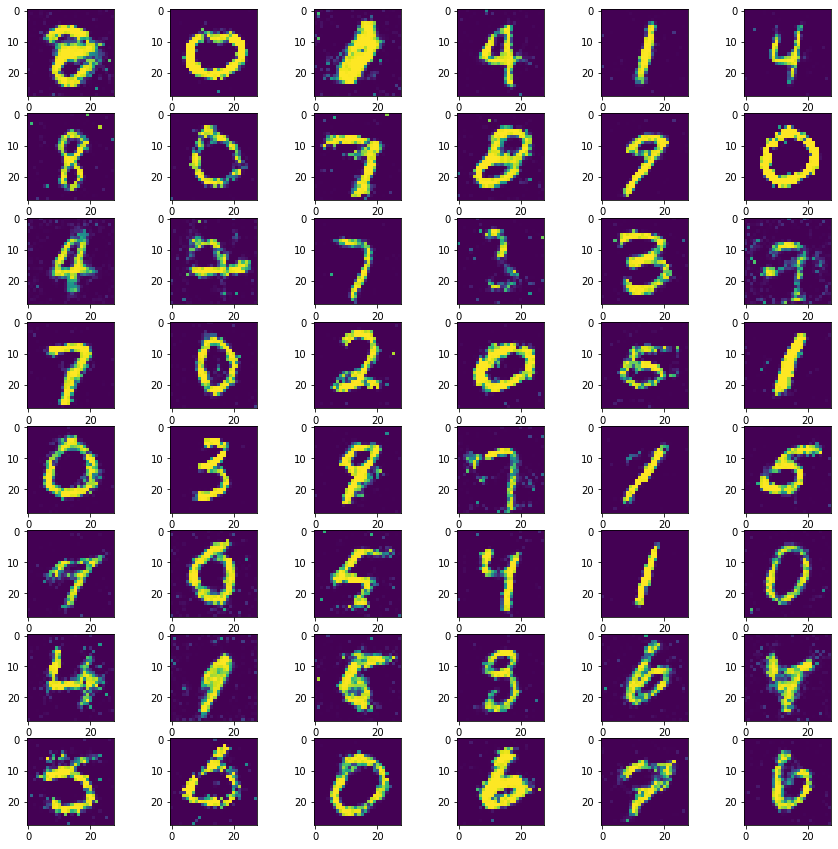

In [5]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (48,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 8
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

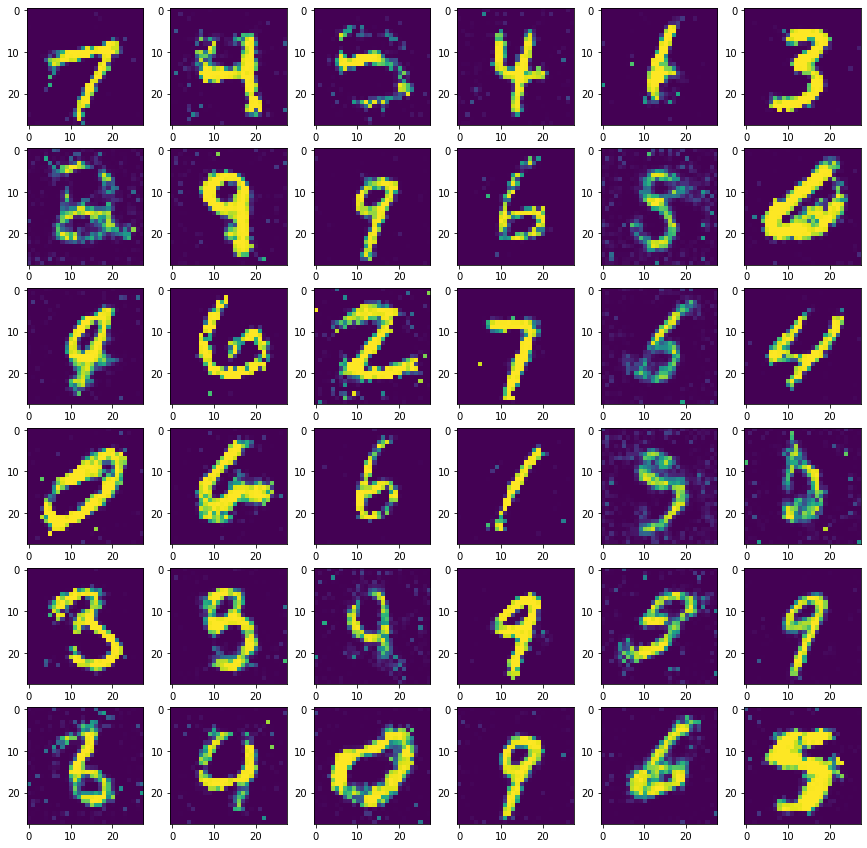

In [6]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

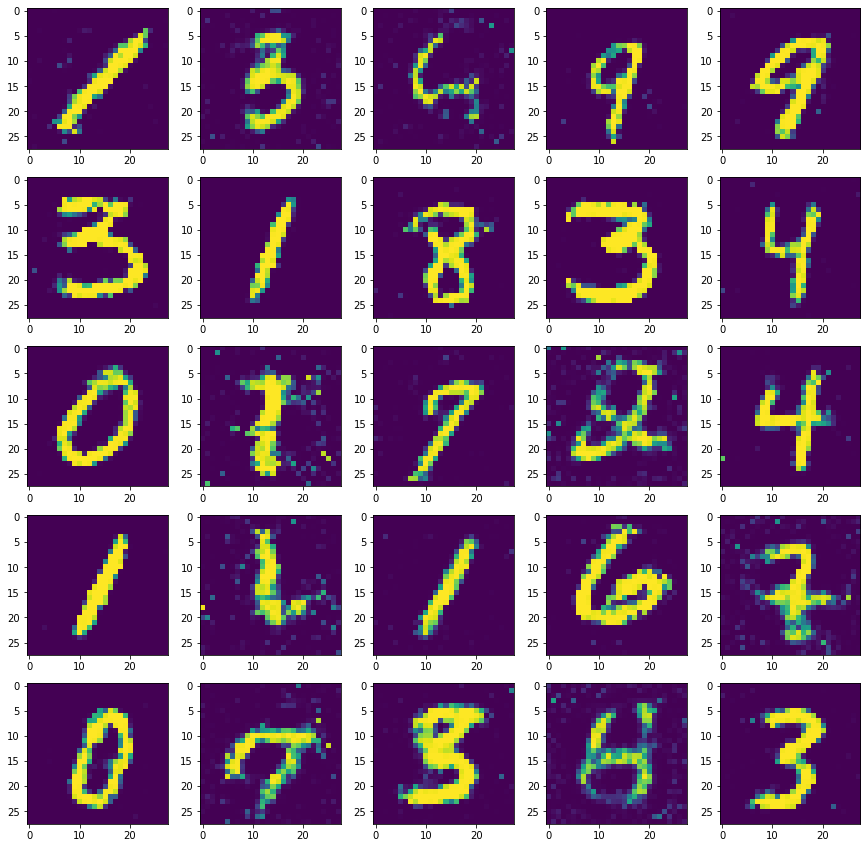

In [7]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (25,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

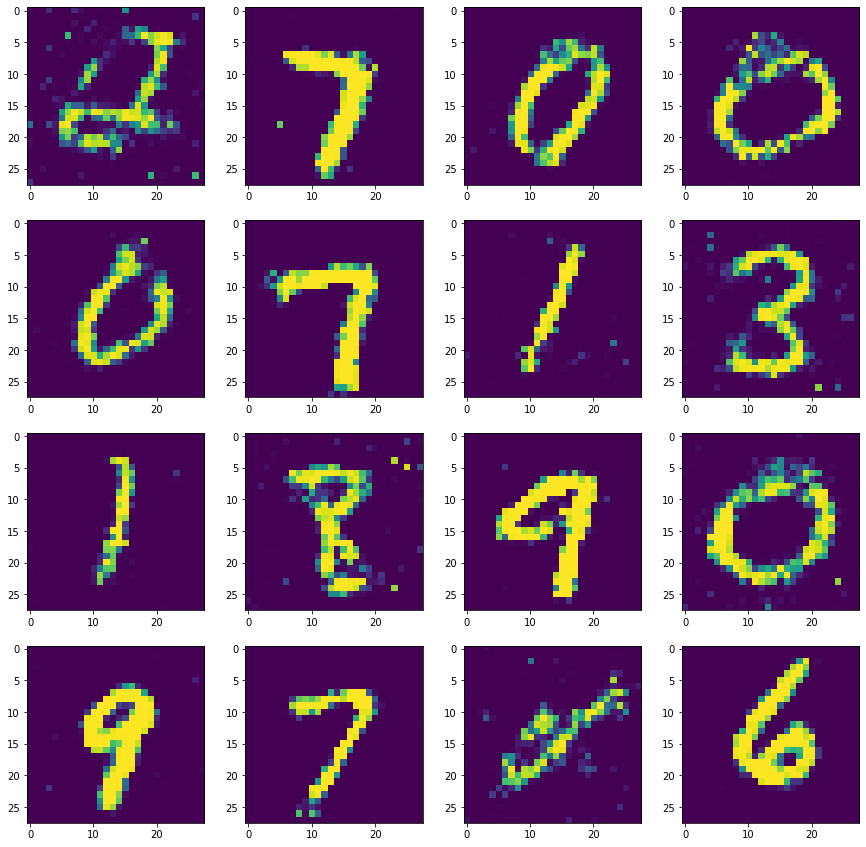

In [8]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

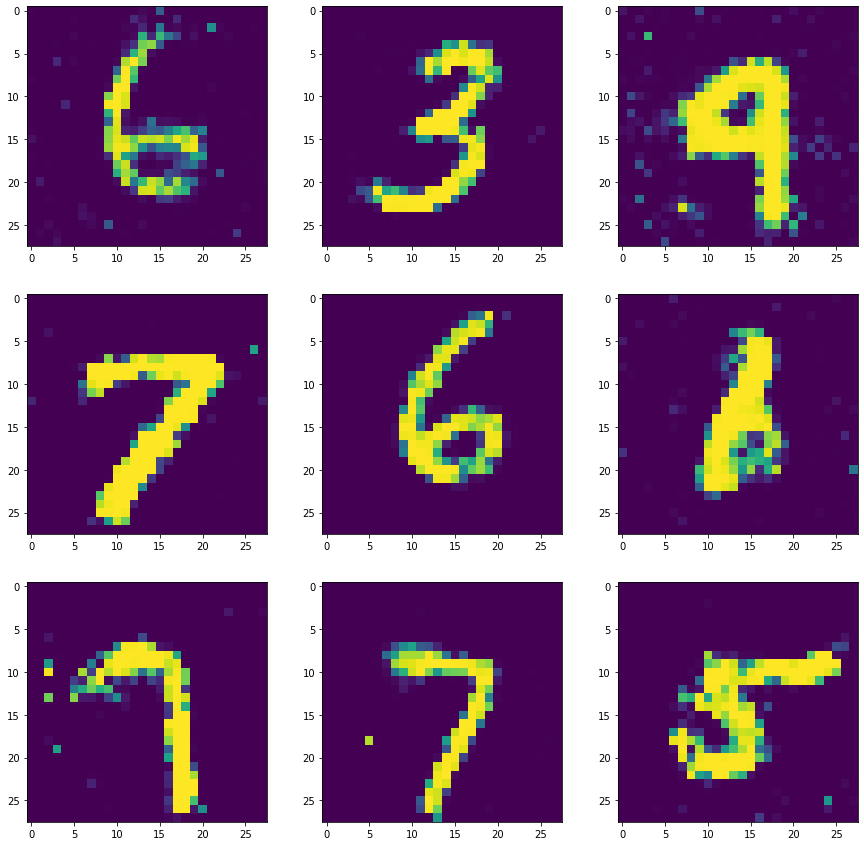

In [9]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

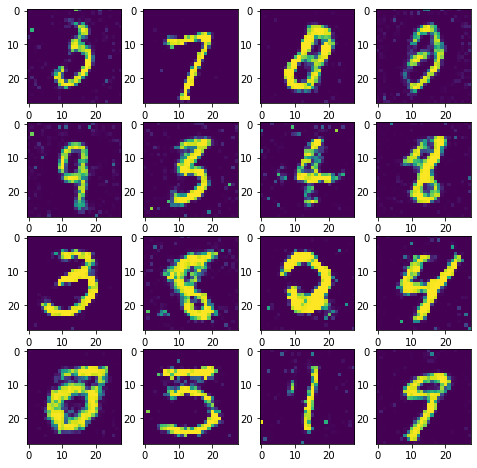

In [10]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

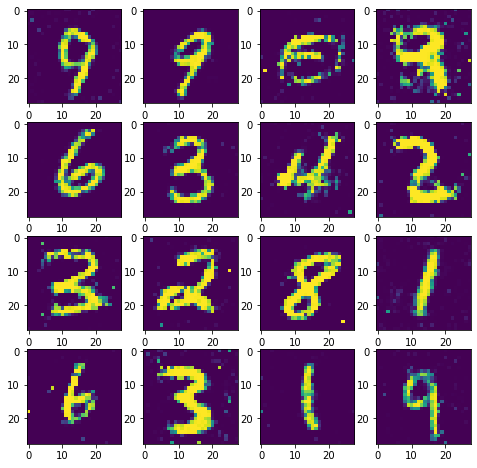

In [11]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

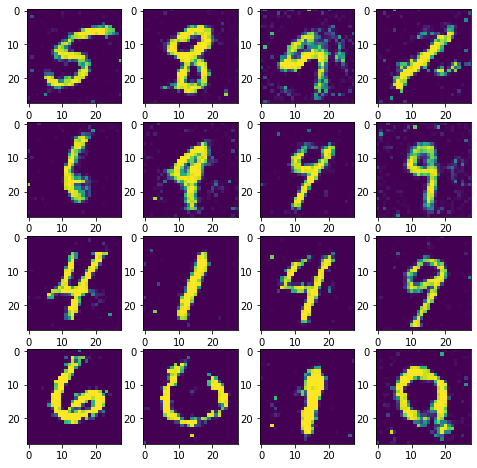

In [12]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

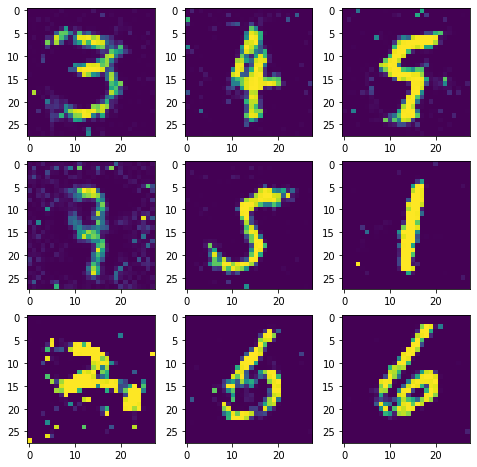

In [13]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
# 1 2 3 4 5 6 6 9

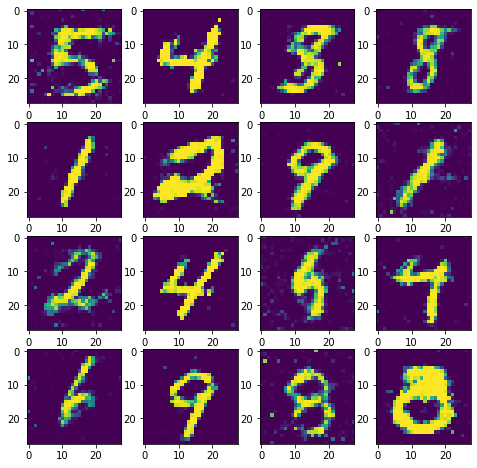

In [15]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (16,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
# 1 2 3(1,3) 4 5 6 7(2,4) 8 9

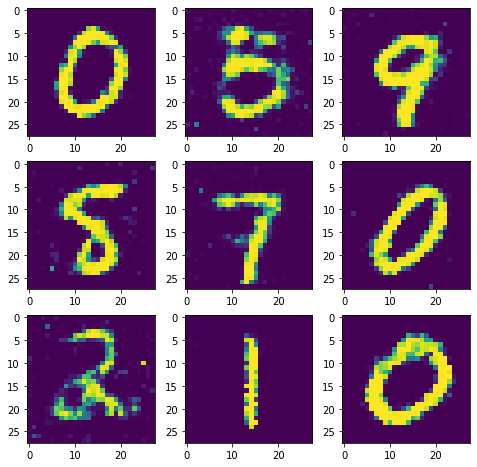

In [16]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

[[ 1.48879044  0.94810255 -0.31240159 ...  0.71002204  0.26700546
   0.44694521]
 [-0.30069523 -0.14306725 -0.94079997 ... -0.49626436  1.08518141
   0.40558634]
 [ 0.66014249  1.08793092 -0.41506988 ... -1.6312651  -1.82491333
  -0.82314653]
 ...
 [ 0.61913311  0.19121624 -1.84922115 ...  0.51421547  1.59953176
  -0.67376716]
 [-0.62958853 -0.71541031  0.58598469 ...  2.33080057 -0.86287223
  -0.32867967]
 [ 0.09257801  0.60954699  0.58984095 ... -0.58592774 -1.22088189
  -0.43189229]]


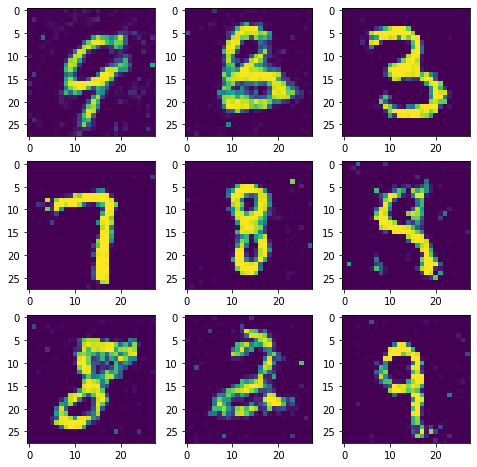

In [32]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (9,128))
print(noise)

gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

In [34]:
import pandas as pd

In [138]:
noise = np.random.normal(0, 1, (9,128))

In [89]:
noise.shape

(9, 128)

In [139]:
pd.DataFrame(noise).to_csv("noises.csv", index=None)
my_file = pd.read_csv('noises.csv')
new_noise = my_file.to_numpy()

In [93]:
new_noise

array([[ 1.21621081,  0.54200846, -1.31299306, ..., -0.44579647,
         0.1516918 , -0.33583957],
       [-0.42343644, -0.73839526,  2.13318335, ...,  0.36508036,
        -0.39275971,  0.96042857],
       [-0.01509121,  0.08410917, -0.30960229, ...,  0.36203523,
         0.45442284, -0.67874249],
       ...,
       [-0.51569799, -0.53929808,  0.11131578, ...,  1.66972035,
         0.34153343,  0.82108173],
       [ 1.35970865, -0.00426792, -0.82236597, ...,  0.75493298,
         2.24662256,  1.91201039],
       [-0.67030005, -1.5637796 ,  0.06942966, ...,  0.03874392,
        -0.48930403, -0.74160609]])

In [94]:
new_noise.shape

(9, 128)

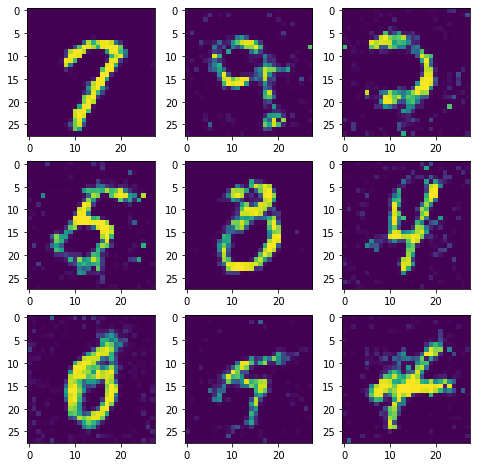

In [95]:
#First generated noise
noise = new_noise
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

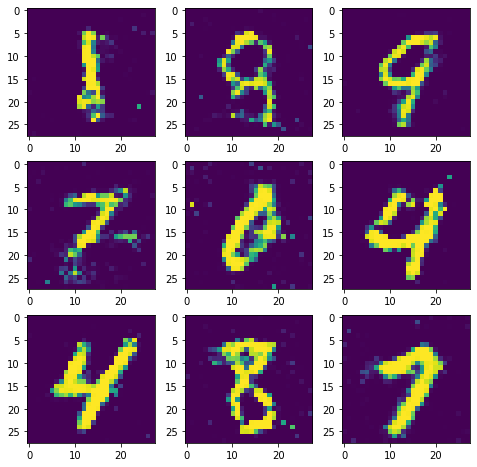

In [111]:
#Second generated noise
noise = new_noise
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

#1
#8 8
#9 
#7 7
# 0
# 4 4

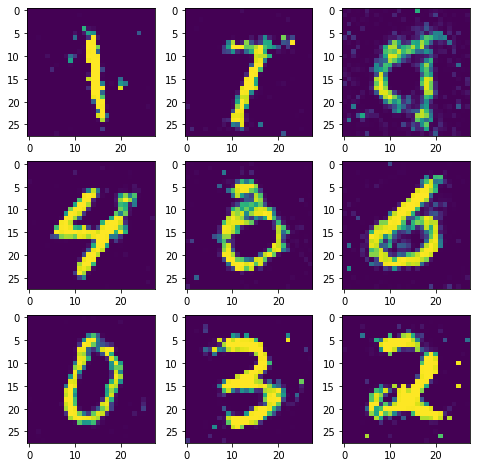

In [128]:
#Third generated noise
noise = new_noise
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

#1
#7
#unknown
#4
#8
#6
#0
#3
#2

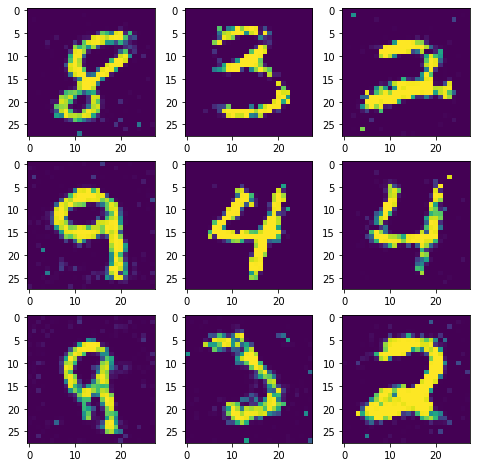

In [140]:
#4th generated noise
noise = new_noise
gen_imgs, distances = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()
#8
#3 3
#2 2
#9
#4 4
# 8